In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/Consulting/data/UncwSeasonData.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-27-1e5f6729c530>:5: DtypeWarning: Columns (27,93,94,96,158) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/My Drive/Consulting/data/UncwSeasonData.csv')


In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/Consulting/data/UncwSeasonData.csv'
uncw_data = pd.read_csv(file_path)
distinct_play_results = uncw_data['PlayResult'].unique()
print(distinct_play_results)

[nan 'Undefined' 'Double' 'Out' 'Single' 'Error' 'FieldersChoice'
 'HomeRun' 'Sacrifice' 'Triple' 'StolenBase' 'CaughtStealing']


<ipython-input-28-13436aa23f22>:5: DtypeWarning: Columns (27,93,94,96,158) have mixed types. Specify dtype option on import or set low_memory=False.
  uncw_data = pd.read_csv(file_path)


In [ ]:
distinct_play_results = uncw_data['BatterTeam'].unique()
print(distinct_play_results)

[nan 'KS_GF' 'UNC_SEA' 'COA_CHA' 'PRI_TIG' 'AIR_FOR' 'LIB_FLA' 'SAL_JAG'
 'BOC_EAG' 'STJ_HAW' 'ECU_PIR' 'ELO_PHO' 'COL_CHA' 'NOR_WOL' 'TOW_TIG'
 'WAK_DEA' 'WM_TRI' 'CHA_BUC' 'CAM_CAM' 'HOF_PRI' 'DEL_BLU' 'GIT_YEL'
 'GEO_BUL']


# Defining Leverage

In [ ]:
data = data.sort_values(by=['Date', 'Inning', 'PitchNo']).reset_index(drop=True)


data['uncw_score'] = 0
data['away_score'] = 0

uncw_team = 'UNC_SEA'

# Iterate through each game
for date, game_data in data.groupby('Date'):
    uncw_score = 0
    away_score = 0

    # Loop through each row
    for index, row in game_data.iterrows():
        if row['BatterTeam'] == uncw_team:
            uncw_score += row['RunsScored']
        else:
            away_score += row['RunsScored']

        data.at[index, 'uncw_score'] = uncw_score
        data.at[index, 'away_score'] = away_score

data[['Date', 'BatterTeam', 'RunsScored', 'uncw_score', 'away_score', 'Inning', 'PitchNo']].head(250)

,Date,BatterTeam,RunsScored,uncw_score,away_score,Inning,PitchNo
0,2/16/2024,KS_GF,0.0,0,0,1.0,1.0
1,2/16/2024,KS_GF,0.0,0,0,1.0,2.0
2,2/16/2024,KS_GF,0.0,0,0,1.0,3.0
3,2/16/2024,KS_GF,0.0,0,0,1.0,4.0
4,2/16/2024,KS_GF,0.0,0,0,1.0,5.0
...,...,...,...,...,...,...,...
245,2/16/2024,UNC_SEA,1.0,7,2,8.0,247.0
246,2/16/2024,UNC_SEA,0.0,7,2,8.0,248.0
247,2/16/2024,UNC_SEA,0.0,7,2,8.0,249.0
248,2/16/2024,UNC_SEA,0.0,7,2,8.0,250.0


In [ ]:
# Create a new column 'runs_difference' for UNCW
# This column will be positive if UNCW is leading, negative if they are behind
data['runs_difference'] = data['uncw_score'] - data['away_score']
print(data[['Date', 'BatterTeam', 'RunsScored', 'uncw_score', 'away_score', 'runs_difference', 'Inning', 'PitchNo']].head(500))

          Date BatterTeam  RunsScored  uncw_score  away_score  \
0    2/16/2024      KS_GF         0.0           0           0   
1    2/16/2024      KS_GF         0.0           0           0   
2    2/16/2024      KS_GF         0.0           0           0   
3    2/16/2024      KS_GF         0.0           0           0   
4    2/16/2024      KS_GF         0.0           0           0   
..         ...        ...         ...         ...         ...   
495  2/17/2024      KS_GF         0.0           1           6   
496  2/17/2024      KS_GF         0.0           1           6   
497  2/17/2024      KS_GF         0.0           1           6   
498  2/17/2024      KS_GF         0.0           1           6   
499  2/17/2024      KS_GF         0.0           1           6   

     runs_difference  Inning  PitchNo  
0                  0     1.0      1.0  
1                  0     1.0      2.0  
2                  0     1.0      3.0  
3                  0     1.0      4.0  
4                  

In [ ]:
# Define leverage
def classify_leverage(runs_diff, inning):
    if abs(runs_diff) > 5:
        return 'Low'
    elif 3 <= abs(runs_diff) <= 5:
        return 'Medium'
    else:
        # Only consider high leverage in innings 6 or later
        if inning >= 6:
            return 'High'
        else:
            return 'Medium'

# Apply the classify_leverage function
data['leverage'] = data.apply(lambda row: classify_leverage(row['runs_difference'], row['Inning']), axis=1)

print(data[['Date', 'BatterTeam', 'uncw_score', 'away_score', 'runs_difference', 'Inning', 'leverage']].head(2000))

           Date BatterTeam  uncw_score  away_score  runs_difference  Inning  \
0     2/16/2024      KS_GF           0           0                0     1.0   
1     2/16/2024      KS_GF           0           0                0     1.0   
2     2/16/2024      KS_GF           0           0                0     1.0   
3     2/16/2024      KS_GF           0           0                0     1.0   
4     2/16/2024      KS_GF           0           0                0     1.0   
...         ...        ...         ...         ...              ...     ...   
1995  2/25/2024    UNC_SEA           4           1                3     5.0   
1996  2/25/2024    UNC_SEA           4           1                3     5.0   
1997  2/25/2024    UNC_SEA           4           1                3     5.0   
1998  2/25/2024    UNC_SEA           4           1                3     5.0   
1999  2/25/2024    PRI_TIG           4           1                3     6.0   

     leverage  
0      Medium  
1      Medium  
2  

In [ ]:
data['men_on_base'] = 0
for (date, inning, half), inning_data in data.groupby(['Date', 'Inning', 'Top/Bottom']):
    men_on_base = 0  # Start with 0 men on base at the beginning of each half-inning

    for index, row in inning_data.iterrows():
        # Check if a player reaches base
        if row['PlayResult'] in ['Single', 'Double', 'Triple', 'Hit By Pitch']:
            men_on_base += 1
        elif row['KorBB'] == 'Walk':
            men_on_base += 1

        # Special handling for home runs
        if row['PlayResult'] == 'HomeRun':
            men_on_base = 0

        else:
            if row['RunsScored'] > 0:
                men_on_base = max(0, men_on_base - row['RunsScored'])

        # Check if there's a play that results in an out on base
        if row['PlayResult'] in ['Pickoff', 'Double Play', 'Caught Stealing']:
            men_on_base = max(0, men_on_base - 1)

        # Additional condition: If OutsOnPlay is 2, subtract an additional man on base
        if row['OutsOnPlay'] == 2:
            men_on_base = max(0, men_on_base - 1)  # Subtracting one additional for double plays or similar

        # Update the 'men_on_base' column for the current play
        data.at[index, 'men_on_base'] = men_on_base

print(data[['Date', 'Inning', 'Top/Bottom', 'PlayResult', 'KorBB', 'RunsScored', 'OutsOnPlay', 'men_on_base']].head(20))

         Date  Inning Top/Bottom PlayResult      KorBB  RunsScored  \
0   2/16/2024     1.0        Top  Undefined  Undefined         0.0   
1   2/16/2024     1.0        Top  Undefined  Undefined         0.0   
2   2/16/2024     1.0        Top  Undefined  Undefined         0.0   
3   2/16/2024     1.0        Top  Undefined  Strikeout         0.0   
4   2/16/2024     1.0        Top     Double  Undefined         0.0   
5   2/16/2024     1.0        Top  Undefined  Undefined         0.0   
6   2/16/2024     1.0        Top  Undefined  Undefined         0.0   
7   2/16/2024     1.0        Top        Out  Undefined         0.0   
8   2/16/2024     1.0        Top  Undefined  Undefined         0.0   
9   2/16/2024     1.0        Top  Undefined  Undefined         0.0   
10  2/16/2024     1.0        Top  Undefined  Strikeout         0.0   
11  2/16/2024     1.0     Bottom  Undefined  Undefined         0.0   
12  2/16/2024     1.0     Bottom  Undefined  Undefined         0.0   
13  2/16/2024     1.

In [ ]:
# Define adjusted score calculation based on runs_difference, men_on_base, and whether UNCW is batting or pitching
def calculate_adjusted_score(runs_diff, men_on_base, batter_team):
    if batter_team == 'UNC_SEA':
        if abs(runs_diff) <= 3:
            # If the score difference is within 3, we do not adjust
            adjusted_score = runs_diff
        elif runs_diff < 0:
            # UNCW is trailing by more than 3, so reduce the deficit by adding men on base
            adjusted_score = runs_diff + men_on_base
        else:
            # UNCW is leading by more than 3, so increase the lead by subtracting men on base
            adjusted_score = runs_diff
    else:  # UNCW is pitching
        if runs_diff > 0:
            # UNCW is leading, so decrease the lead by the number of men on base
            adjusted_score = runs_diff - men_on_base
        else:
            # UNCW is trailing, so increase the deficit by adding men on base
            adjusted_score = runs_diff
    return adjusted_score

# Define leverage based on the adjusted score difference
def classify_leverage(adjusted_score, inning):
    if abs(adjusted_score) > 5:
        return 'Low'
    elif abs(adjusted_score) <= 3 and inning >= 5:
        return 'High'
    else:
        return 'Medium'

# Calculate adjusted score and leverage
data['adjusted_score'] = data.apply(lambda row: calculate_adjusted_score(row['runs_difference'], row['men_on_base'], row['BatterTeam']), axis=1)
data['leverage'] = data.apply(lambda row: classify_leverage(row['adjusted_score'], row['Inning']), axis=1)

print(data[['Date', 'Inning', 'BatterTeam', 'runs_difference', 'men_on_base', 'adjusted_score', 'leverage']].head(20))

         Date  Inning BatterTeam  runs_difference  men_on_base  \
0   2/16/2024     1.0      KS_GF                0            0   
1   2/16/2024     1.0      KS_GF                0            0   
2   2/16/2024     1.0      KS_GF                0            0   
3   2/16/2024     1.0      KS_GF                0            0   
4   2/16/2024     1.0      KS_GF                0            1   
5   2/16/2024     1.0      KS_GF                0            1   
6   2/16/2024     1.0      KS_GF                0            1   
7   2/16/2024     1.0      KS_GF                0            1   
8   2/16/2024     1.0      KS_GF                0            1   
9   2/16/2024     1.0      KS_GF                0            1   
10  2/16/2024     1.0      KS_GF                0            1   
11  2/16/2024     1.0    UNC_SEA                0            0   
12  2/16/2024     1.0    UNC_SEA                0            0   
13  2/16/2024     1.0    UNC_SEA                0            0   
14  2/16/2

# Leverage FIlter

In [ ]:
data.to_csv('/content/drive/My Drive/Consulting/data/uncw_leverage.csv', index=False)

print("Dataset exported successfully as 'uncw_leverage.csv' in the specified directory.")

Dataset exported successfully as 'uncw_leverage.csv' in the specified directory.


In [ ]:
leverage_data = pd.read_csv('/content/drive/My Drive/Consulting/data/uncw_leverage.csv',low_memory= False)

## ERA

In [ ]:
import pandas as pd

def calculate_era(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    # Initializer
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Filter data
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]
        # Initializers
        earned_runs = 0
        outs = 0

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # At the start of each inning, reset baserunners
            baserunners = set()

            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                PitchCall = row['PitchCall']
                bborK = row['KorBB']
                outs_on_play = row.get('OutsOnPlay', 0)

                # home runs: immediate earned run
                if play_result == 'HomeRun':
                    earned_runs += 1

                # Add batter to baserunners for singles, doubles, triples, and walks
                if play_result in ['Single', 'Double', 'Triple'] or bborK == 'Walk' and play_result not in ['Error'] or PitchCall in 'HitByPitch':
                    baserunners.add(row['BatterId'])

                # Count outs
                if play_result in ['Out', 'FieldersChoice', 'Sacrifice' , 'CaughtStealing']:
                    outs += 1
                if bborK == 'Strikeout':
                    outs += 1

                # Account for double plays
                if outs_on_play == 2:
                    outs += 1

                # Check if any baserunners scored on this play
                runs_scored = row.get('RunsScored', 0)
                if runs_scored > 0:
                    for _ in range(int(runs_scored)):
                        if baserunners:
                            earned_runs += 1
                            baserunners.pop()

            # Reset baserunners at the end of the inning
            baserunners.clear()

        # Calculate innings pitched
        innings_pitched = outs / 3
        # Calculate ERA
        era = (earned_runs / innings_pitched) * 9 if innings_pitched > 0 else 0
        # Store stats
        pitcher_stats[pitcher] = {
            'earned_runs': earned_runs,
            'innings_pitched': innings_pitched,
            'ERA': era
        }

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

# Usage example:
# df = pd.read_excel('path_to_your_data.xlsx', sheet_name='uncw_leverage')
pitcher_era_df = calculate_era(leverage_data)
print(pitcher_era_df)


              Pitcher  earned_runs  innings_pitched        ERA
0           Sales, RJ           23        71.666667   2.888372
1         Craig, Luke           13        42.333333   2.763780
2        Kane, Connor           11        23.666667   4.183099
3       Shafer, Jacob           34        57.333333   5.337209
4        Stroup, Case            8        21.000000   3.428571
5        Baker, Trace            9        22.000000   3.681818
6          Lawson, Ty            0         1.666667   0.000000
7        Benton, Cole            4         8.333333   4.320000
8      Murdock, Mason           10        10.333333   8.709677
9        Taylor, Zane           18        41.333333   3.919355
10      Calvert, Ryan           16        28.333333   5.082353
11  Marshburn, Connor            8        19.000000   3.789474
12      Thach, Tanner            3         6.000000   4.500000
13       Phelan, Cyle            9        13.666667   5.926829
14         Cox, Baker            3         6.333333   4

In [ ]:
import pandas as pd

def calculate_leverage_era(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']

    # Initialize
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define leverage levels
    leverage_levels = ['Low', 'Medium', 'High']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        leverage_stats = {lev: {'earned_runs': 0, 'outs': 0} for lev in leverage_levels}
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # At the start of each inning, reset baserunners
            baserunners = set()

            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                PitchCall = row['PitchCall']
                outs_on_play = row.get('OutsOnPlay', 0)
                leverage = row.get('leverage', 'Medium')  # Default to Medium if leverage is missing

                # Handle home runs: immediate earned run
                if play_result == 'HomeRun':
                    leverage_stats[leverage]['earned_runs'] += 1

                # Add batter to baserunners for singles, doubles, triples, and walks
                if play_result in ['Single', 'Double', 'Triple'] or bborK == 'Walk' and play_result not in ['Error'] or PitchCall in 'HitByPitch':
                    baserunners.add(row['BatterId'])

                # Count outs
                if play_result in ['Out', 'FieldersChoice', 'Sacrifice', 'CaughtStealing']:
                    leverage_stats[leverage]['outs'] += 1
                if bborK == 'Strikeout':
                    leverage_stats[leverage]['outs'] += 1

                # Account for double plays
                if outs_on_play == 2:
                    leverage_stats[leverage]['outs'] += 1  # Add the additional out from the double play

                # Check if any baserunners scored on this play
                runs_scored = row.get('RunsScored', 0)
                if runs_scored > 0:
                    for _ in range(int(runs_scored)):
                        if baserunners:
                            leverage_stats[leverage]['earned_runs'] += 1
                            baserunners.pop()

            # Reset baserunners at the end of the inning
            baserunners.clear()

        # Calculate leverage-based ERA
        for lev in leverage_levels:
            outs = leverage_stats[lev]['outs']
            innings_pitched = outs / 3
            earned_runs = leverage_stats[lev]['earned_runs']
            era = (earned_runs / innings_pitched) * 9 if innings_pitched > 0 else "N/A"
            leverage_stats[lev]['ERA'] = era

        pitcher_stats[pitcher] = {lev: stats['ERA'] for lev, stats in leverage_stats.items()}
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

leverage_era_df = calculate_leverage_era(leverage_data)
print(leverage_era_df)


              Pitcher       Low    Medium      High
0           Sales, RJ       0.0  3.398601       2.5
1         Craig, Luke       0.0       0.0  3.280374
2        Kane, Connor       6.0  1.173913  5.538462
3       Shafer, Jacob       2.7   5.90625       4.5
4        Stroup, Case       N/A  2.769231       4.5
5        Baker, Trace  7.363636  7.363636  1.840909
6          Lawson, Ty       0.0       0.0       0.0
7        Benton, Cole  3.857143       0.0       5.4
8      Murdock, Mason  3.521739      27.0      13.5
9        Taylor, Zane       0.0      3.78  5.142857
10      Calvert, Ryan      27.0  4.909091  4.655172
11  Marshburn, Connor     11.25       0.0  1.883721
12      Thach, Tanner       N/A       9.0       3.6
13       Phelan, Cyle  7.714286  5.558824       N/A
14         Cox, Baker       0.0      18.0       3.0
15  Thornton, Bromley      6.75       N/A       N/A
16      Gaither, Matt      27.0      13.5       N/A
17      Allen, Cooper       N/A  4.764706       5.4
18        Ev

## BAA

In [ ]:
import pandas as pd

def calculate_baa(df):
    # Filter data for UNCW pitchers
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']

    # Initialize a dictionary to store pitcher stats
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats
        hits_allowed = 0
        at_bats = 0

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']

                # Count hits allowed
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    hits_allowed += 1

                # Count at-bats: exclude walks, hit-by-pitches, sacrifices, and errors
                if play_result in ['Double', 'Out', 'Single' ,'Error', 'FieldersChoice','HomeRun', 'Sacrifice' 'Triple'] or bborK == 'Strikeout':
                    at_bats += 1

        # Calculate BAA
        baa = hits_allowed / at_bats if at_bats > 0 else "N/A"

        # Store stats
        pitcher_stats[pitcher] = {
            'hits_allowed': hits_allowed,
            'at_bats': at_bats,
            'BAA': baa
        }

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

pitcher_baa_df = calculate_baa(leverage_data)
print(pitcher_baa_df)

              Pitcher  hits_allowed  at_bats       BAA
0           Sales, RJ            53      259  0.204633
1         Craig, Luke            24      147  0.163265
2        Kane, Connor            24       92  0.260870
3       Shafer, Jacob            58      225  0.257778
4        Stroup, Case            18       76  0.236842
5        Baker, Trace            16       78  0.205128
6          Lawson, Ty             2        6  0.333333
7        Benton, Cole             5       32  0.156250
8      Murdock, Mason             9       37  0.243243
9        Taylor, Zane            36      156  0.230769
10      Calvert, Ryan            28      112  0.250000
11  Marshburn, Connor            19       74  0.256757
12      Thach, Tanner             9       25  0.360000
13       Phelan, Cyle            16       52  0.307692
14         Cox, Baker             7       26  0.269231
15  Thornton, Bromley             2        5  0.400000
16      Gaither, Matt             6       11  0.545455
17      Al

In [ ]:
import pandas as pd

def calculate_leverage_baa(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define leverage levels
    leverage_levels = ['Low', 'Medium', 'High']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats for each leverage level
        leverage_stats = {lev: {'hits_allowed': 0, 'at_bats': 0} for lev in leverage_levels}

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                leverage = row.get('leverage', 'Medium')  # Default to Medium if leverage is missing

                # Count hits allowed for the specific leverage
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    leverage_stats[leverage]['hits_allowed'] += 1

                # Count at-bats: exclude walks, hit-by-pitches, sacrifices, and errors
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun', 'Out', 'StrikeOut'] or bborK == 'Strikeout':
                    leverage_stats[leverage]['at_bats'] += 1

        # Calculate leverage-based BAA
        for lev in leverage_levels:
            hits_allowed = leverage_stats[lev]['hits_allowed']
            at_bats = leverage_stats[lev]['at_bats']
            # Assign BAA or N/A if no at-bats recorded
            baa = hits_allowed / at_bats if at_bats > 0 else "N/A"
            leverage_stats[lev]['BAA'] = baa

        pitcher_stats[pitcher] = {lev: stats['BAA'] for lev, stats in leverage_stats.items()}

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df
leverage_baa_df = calculate_leverage_baa(leverage_data)
print(leverage_baa_df)

              Pitcher       Low    Medium      High
0           Sales, RJ       0.0  0.213018  0.261538
1         Craig, Luke       0.0  0.117647  0.184874
2        Kane, Connor       0.4      0.16      0.28
3       Shafer, Jacob      0.28  0.251613  0.342857
4        Stroup, Case       N/A  0.214286  0.333333
5        Baker, Trace      0.25  0.285714  0.183673
6          Lawson, Ty       0.0       0.5       0.5
7        Benton, Cole  0.142857       0.0  0.210526
8      Murdock, Mason  0.086957  0.555556       0.5
9        Taylor, Zane       0.0  0.245902  0.222222
10      Calvert, Ryan       0.0  0.246575  0.277778
11  Marshburn, Connor    0.3125       0.0  0.269231
12      Thach, Tanner       N/A       0.4      0.35
13       Phelan, Cyle  0.454545  0.263158       1.0
14         Cox, Baker      0.25       0.5       0.2
15  Thornton, Bromley      0.25       1.0       N/A
16      Gaither, Matt       0.6       0.6       N/A
17      Allen, Cooper       N/A  0.318182  0.285714
18        Ev

In [ ]:
import pandas as pd

def calculate_baa_by_handiness(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define handiness categories
    handiness = ['Left', 'Right']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats for each handiness
        handiness_stats = {side: {'hits_allowed': 0, 'at_bats': 0} for side in handiness}

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                batter_side = row['BatterSide']

                # Count hits allowed based on batter handiness
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    handiness_stats[batter_side]['hits_allowed'] += 1

                # Count at-bats: exclude walks, hit-by-pitches, sacrifices, and errors
                if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK == 'Strikeout':
                    handiness_stats[batter_side]['at_bats'] += 1

        # Calculate BAA for each handiness
        for side in handiness:
            hits_allowed = handiness_stats[side]['hits_allowed']
            at_bats = handiness_stats[side]['at_bats']
            # Assign BAA or N/A if no at-bats recorded
            baa = hits_allowed / at_bats if at_bats > 0 else "N/A"
            handiness_stats[side]['BAA'] = baa

        pitcher_stats[pitcher] = {side: stats['BAA'] for side, stats in handiness_stats.items()}

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

handiness_baa_df = calculate_baa_by_handiness(leverage_data)
print(handiness_baa_df)

              Pitcher      Left     Right
0           Sales, RJ  0.157143  0.217617
1         Craig, Luke  0.070175  0.212766
2        Kane, Connor  0.235294  0.266667
3       Shafer, Jacob  0.287671  0.235669
4        Stroup, Case  0.227273  0.222222
5        Baker, Trace  0.227273  0.192982
6          Lawson, Ty       0.0  0.400000
7        Benton, Cole  0.076923  0.210526
8      Murdock, Mason  0.153846  0.269231
9        Taylor, Zane   0.22449  0.227273
10      Calvert, Ryan  0.333333  0.174603
11  Marshburn, Connor  0.321429  0.212766
12      Thach, Tanner       0.4  0.312500
13       Phelan, Cyle  0.333333  0.264706
14         Cox, Baker  0.384615  0.153846
15  Thornton, Bromley       0.5  0.333333
16      Gaither, Matt       1.0  0.444444
17      Allen, Cooper      0.25  0.291667
18        Everett, JD       N/A  0.000000
19       Benton, Cody  0.166667  0.176471
20    Capuano, Jordan       N/A  0.000000
21       Gibson, Jack       0.0  0.375000
22     Holjes, Carter  0.666667  0

## OBP Against

In [ ]:
import pandas as pd

def calculate_obp(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats
        hits = 0
        walks = 0
        hbp = 0
        plate_appearances = 0

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                pitch_call = row['PitchCall']

                # Count hits
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    hits += 1

                # Count walks
                if bborK == 'Walk':
                    walks += 1

                # Count hit by pitch
                if pitch_call == 'HitByPitch':
                    hbp += 1

                # Count plate appearances
                if play_result in ['Double', 'Out', 'Single' ,'Error', 'FieldersChoice','HomeRun', 'Sacrifice' ,'Triple'] or bborK in ['Walk','Strikeout'] or pitch_call == 'HitByPitch':
                    plate_appearances += 1

        # Calculate OBP
        obp = (hits + walks + hbp) / plate_appearances if plate_appearances > 0 else "N/A"

        # Store stats
        pitcher_stats[pitcher] = {
            'hits': hits,
            'walks': walks,
            'hbp': hbp,
            'plate_appearances': plate_appearances,
            'OBP': obp
        }

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

obp_df = calculate_obp(leverage_data)
print(obp_df)

              Pitcher  hits  walks  hbp  plate_appearances       OBP
0           Sales, RJ    53     36    6                305  0.311475
1         Craig, Luke    24     18    5                173  0.271676
2        Kane, Connor    24     14    1                108  0.361111
3       Shafer, Jacob    58     25    7                260  0.346154
4        Stroup, Case    18     13    5                 98  0.367347
5        Baker, Trace    16     15    3                 97  0.350515
6          Lawson, Ty     2      4    0                 10  0.600000
7        Benton, Cole     5      5    3                 39  0.333333
8      Murdock, Mason     9      8    5                 51  0.431373
9        Taylor, Zane    36     11    4                174  0.293103
10      Calvert, Ryan    28     13    3                129  0.341085
11  Marshburn, Connor    19     14    8                 97  0.422680
12      Thach, Tanner     9      1    0                 27  0.370370
13       Phelan, Cyle    16     13

In [ ]:
import pandas as pd

def calculate_leverage_obp(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define leverage levels
    leverage_levels = ['Low', 'Medium', 'High']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats for each leverage level
        leverage_stats = {lev: {'hits': 0, 'walks': 0, 'hbp': 0, 'plate_appearances': 0} for lev in leverage_levels}

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                pitch_call = row['PitchCall']
                leverage = row.get('leverage', 'Medium')  # Default to Medium if leverage is missing

                # Count hits for the specific leverage
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    leverage_stats[leverage]['hits'] += 1

                # Count walks for the specific leverage
                if bborK == 'Walk':
                    leverage_stats[leverage]['walks'] += 1

                # Count hit by pitch for the specific leverage
                if pitch_call == 'HitByPitch':
                    leverage_stats[leverage]['hbp'] += 1

                # Count plate appearances for the specific leverage
                if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK in ['Walk', 'Strikeout'] or pitch_call == 'HitByPitch':
                    leverage_stats[leverage]['plate_appearances'] += 1

        # Calculate leverage-based OBP
        for lev in leverage_levels:
            hits = leverage_stats[lev]['hits']
            walks = leverage_stats[lev]['walks']
            hbp = leverage_stats[lev]['hbp']
            plate_appearances = leverage_stats[lev]['plate_appearances']

            # Assign OBP or N/A if no plate appearances recorded
            obp = (hits + walks + hbp) / plate_appearances if plate_appearances > 0 else "N/A"
            leverage_stats[lev]['OBP'] = obp

        pitcher_stats[pitcher] = {lev: stats['OBP'] for lev, stats in leverage_stats.items()}

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df
leverage_obp_df = calculate_leverage_obp(leverage_data)
print(leverage_obp_df)

              Pitcher       Low    Medium      High
0           Sales, RJ       0.1  0.321951    0.3375
1         Craig, Luke       0.0  0.190476  0.288591
2        Kane, Connor    0.4375   0.30303  0.372881
3       Shafer, Jacob  0.307692  0.341969  0.390244
4        Stroup, Case       N/A  0.339286  0.404762
5        Baker, Trace  0.388889  0.388889  0.327869
6          Lawson, Ty       0.5      0.75       0.5
7        Benton, Cole  0.181818  0.571429  0.333333
8      Murdock, Mason  0.233333  0.615385     0.875
9        Taylor, Zane       0.0  0.302817  0.275862
10      Calvert, Ryan       0.0  0.325301  0.377778
11  Marshburn, Connor   0.47619       0.0  0.418919
12      Thach, Tanner       N/A       0.4  0.363636
13       Phelan, Cyle  0.666667  0.388889       1.0
14         Cox, Baker  0.222222       0.5  0.307692
15  Thornton, Bromley      0.25       1.0       N/A
16      Gaither, Matt  0.666667  0.666667       N/A
17      Allen, Cooper       N/A       0.4  0.285714
18        Ev

In [ ]:
import pandas as pd

def calculate_baa_by_handiness(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define handiness categories
    handiness = ['Left', 'Right']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats for each handiness
        handiness_stats = {side: {'hits_allowed': 0, 'at_bats': 0} for side in handiness}

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                batter_side = row['BatterSide']

                # Count hits allowed based on batter handiness
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    handiness_stats[batter_side]['hits_allowed'] += 1

                # Count at-bats: exclude walks, hit-by-pitches, sacrifices, and errors
                if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK == 'Strikeout':
                    handiness_stats[batter_side]['at_bats'] += 1

        # Calculate BAA for each handiness
        for side in handiness:
            hits_allowed = handiness_stats[side]['hits_allowed']
            at_bats = handiness_stats[side]['at_bats']
            # Assign BAA or N/A if no at-bats recorded
            baa = hits_allowed / at_bats if at_bats > 0 else "N/A"
            handiness_stats[side]['BAA'] = baa

        pitcher_stats[pitcher] = {side: stats['BAA'] for side, stats in handiness_stats.items()}

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df
handiness_baa_df = calculate_baa_by_handiness(leverage_data)
print(handiness_baa_df)

              Pitcher      Left     Right
0           Sales, RJ  0.157143  0.217617
1         Craig, Luke  0.070175  0.212766
2        Kane, Connor  0.235294  0.266667
3       Shafer, Jacob  0.287671  0.235669
4        Stroup, Case  0.227273  0.222222
5        Baker, Trace  0.227273  0.192982
6          Lawson, Ty       0.0  0.400000
7        Benton, Cole  0.076923  0.210526
8      Murdock, Mason  0.153846  0.269231
9        Taylor, Zane   0.22449  0.227273
10      Calvert, Ryan  0.333333  0.174603
11  Marshburn, Connor  0.321429  0.212766
12      Thach, Tanner       0.4  0.312500
13       Phelan, Cyle  0.333333  0.264706
14         Cox, Baker  0.384615  0.153846
15  Thornton, Bromley       0.5  0.333333
16      Gaither, Matt       1.0  0.444444
17      Allen, Cooper      0.25  0.291667
18        Everett, JD       N/A  0.000000
19       Benton, Cody  0.166667  0.176471
20    Capuano, Jordan       N/A  0.000000
21       Gibson, Jack       0.0  0.375000
22     Holjes, Carter  0.666667  0

## Slugging Against

In [ ]:
import pandas as pd

def calculate_slg_against(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats
        total_bases = 0
        at_bats = 0

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']

                # Count total bases based on play result
                if play_result == 'Single':
                    total_bases += 1
                elif play_result == 'Double':
                    total_bases += 2
                elif play_result == 'Triple':
                    total_bases += 3
                elif play_result == 'HomeRun':
                    total_bases += 4

                # Count at-bats: exclude walks, hit-by-pitches, sacrifices, and errors
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun', 'Out', 'StrikeOut', 'FieldersChoice']:
                    at_bats += 1

        # Calculate SLG
        slg = total_bases / at_bats if at_bats > 0 else "N/A"

        # Store stats
        pitcher_stats[pitcher] = {
            'total_bases': total_bases,
            'at_bats': at_bats,
            'SLG': slg
        }

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

slg_df = calculate_slg_against(leverage_data)
print(slg_df)

              Pitcher  total_bases  at_bats       SLG
0           Sales, RJ           73      191  0.382199
1         Craig, Luke           32       90  0.355556
2        Kane, Connor           33       70  0.471429
3       Shafer, Jacob           90      170  0.529412
4        Stroup, Case           29       57  0.508772
5        Baker, Trace           31       53  0.584906
6          Lawson, Ty            3        5       0.6
7        Benton, Cole            9       23  0.391304
8      Murdock, Mason           12       23  0.521739
9        Taylor, Zane           68      116  0.586207
10      Calvert, Ryan           49       70       0.7
11  Marshburn, Connor           24       49  0.489796
12      Thach, Tanner           16       18  0.888889
13       Phelan, Cyle           18       38  0.473684
14         Cox, Baker           11       22       0.5
15  Thornton, Bromley            4        4       1.0
16      Gaither, Matt            9       10       0.9
17      Allen, Cooper       

In [ ]:
import pandas as pd

def calculate_leverage_slg_against(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define leverage levels
    leverage_levels = ['Low', 'Medium', 'High']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats for each leverage level
        leverage_stats = {lev: {'total_bases': 0, 'at_bats': 0} for lev in leverage_levels}

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                leverage = row.get('leverage', 'Medium')  # Default to Medium if leverage is missing

                # Count total bases based on play result for the specific leverage
                if play_result == 'Single':
                    leverage_stats[leverage]['total_bases'] += 1
                elif play_result == 'Double':
                    leverage_stats[leverage]['total_bases'] += 2
                elif play_result == 'Triple':
                    leverage_stats[leverage]['total_bases'] += 3
                elif play_result == 'HomeRun':
                    leverage_stats[leverage]['total_bases'] += 4

                # Count at-bats for the specific leverage
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun', 'Out', 'StrikeOut', 'FieldersChoice']:
                    leverage_stats[leverage]['at_bats'] += 1

        # Calculate leverage-based SLG
        for lev in leverage_levels:
            total_bases = leverage_stats[lev]['total_bases']
            at_bats = leverage_stats[lev]['at_bats']
            # Assign SLG or N/A if no at-bats recorded
            slg = total_bases / at_bats if at_bats > 0 else "N/A"
            leverage_stats[lev]['SLG'] = slg

        pitcher_stats[pitcher] = {lev: stats['SLG'] for lev, stats in leverage_stats.items()}

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

leverage_slg_df = calculate_leverage_slg_against(leverage_data)
print(leverage_slg_df)

              Pitcher       Low    Medium      High
0           Sales, RJ       0.0       0.4  0.403846
1         Craig, Luke       0.0  0.181818  0.384615
2        Kane, Connor  0.833333  0.263158  0.461538
3       Shafer, Jacob  0.416667  0.504132      0.76
4        Stroup, Case       N/A  0.514286       0.5
5        Baker, Trace  0.818182       1.0     0.375
6          Lawson, Ty       0.0       1.0       1.0
7        Benton, Cole  0.333333       0.0  0.466667
8      Murdock, Mason  0.153846  1.142857  0.666667
9        Taylor, Zane       0.0  0.526316       1.0
10      Calvert, Ryan       N/A  0.813953  0.518519
11  Marshburn, Connor  0.583333       N/A  0.459459
12      Thach, Tanner       N/A      1.25  0.785714
13       Phelan, Cyle  0.555556  0.428571       1.0
14         Cox, Baker  0.285714  0.666667  0.555556
15  Thornton, Bromley  0.666667       2.0       N/A
16      Gaither, Matt       0.5       1.5       N/A
17      Allen, Cooper       N/A  0.368421  0.857143
18        Ev

In [ ]:
import pandas as pd

def calculate_slg_against_by_handiness(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define handiness categories
    handiness = ['Left', 'Right']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats for each handiness
        handiness_stats = {side: {'total_bases': 0, 'at_bats': 0} for side in handiness}

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                batter_side = row['BatterSide']

                # Count total bases based on play result for the specific batter handiness
                if play_result == 'Single':
                    handiness_stats[batter_side]['total_bases'] += 1
                elif play_result == 'Double':
                    handiness_stats[batter_side]['total_bases'] += 2
                elif play_result == 'Triple':
                    handiness_stats[batter_side]['total_bases'] += 3
                elif play_result == 'HomeRun':
                    handiness_stats[batter_side]['total_bases'] += 4

                # Count at-bats for the specific batter handiness
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun', 'Out', 'StrikeOut', 'FieldersChoice']:
                    handiness_stats[batter_side]['at_bats'] += 1

        # Calculate SLG for each handiness
        for side in handiness:
            total_bases = handiness_stats[side]['total_bases']
            at_bats = handiness_stats[side]['at_bats']
            # Assign SLG or N/A if no at-bats recorded
            slg = total_bases / at_bats if at_bats > 0 else "N/A"
            handiness_stats[side]['SLG'] = slg

        pitcher_stats[pitcher] = {side: stats['SLG'] for side, stats in handiness_stats.items()}

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

handiness_slg_df = calculate_slg_against_by_handiness(leverage_data)
print(handiness_slg_df)

              Pitcher      Left     Right
0           Sales, RJ  0.387755  0.380282
1         Craig, Luke     0.125  0.482759
2        Kane, Connor  0.407407  0.511628
3       Shafer, Jacob  0.690909  0.452174
4        Stroup, Case  0.516129       0.5
5        Baker, Trace  0.411765  0.666667
6          Lawson, Ty       0.0      0.75
7        Benton, Cole  0.090909  0.666667
8      Murdock, Mason  0.222222  0.714286
9        Taylor, Zane  0.457143  0.641975
10      Calvert, Ryan   0.96875  0.473684
11  Marshburn, Connor      0.55  0.448276
12      Thach, Tanner  1.666667       0.5
13       Phelan, Cyle  0.538462      0.44
14         Cox, Baker       0.9  0.166667
15  Thornton, Bromley       2.0  0.666667
16      Gaither, Matt       2.5       0.5
17      Allen, Cooper  0.714286  0.421053
18        Everett, JD       N/A       0.0
19       Benton, Cody  0.333333       0.4
20    Capuano, Jordan       N/A       N/A
21       Gibson, Jack       0.0  0.428571
22     Holjes, Carter  1.333333   

## OPS

In [ ]:
import pandas as pd

def calculate_ops(df):
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats
        hits = 0
        walks = 0
        hbp = 0
        total_bases = 0
        plate_appearances = 0
        at_bats = 0

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                pitch_call = row['PitchCall']

                # Count hits
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    hits += 1

                # Count walks
                if bborK == 'Walk':
                    walks += 1

                # Count hit by pitch
                if pitch_call == 'HitByPitch':
                    hbp += 1

                # Count total bases
                if play_result == 'Single':
                    total_bases += 1
                elif play_result == 'Double':
                    total_bases += 2
                elif play_result == 'Triple':
                    total_bases += 3
                elif play_result == 'HomeRun':
                    total_bases += 4

                # Count plate appearances
                if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK in ['Walk', 'StrikeOut'] or pitch_call == 'HitByPitch':
                    plate_appearances += 1

                # Count at-bats
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun', 'Out', 'StrikeOut', 'FieldersChoice']:
                    at_bats += 1

        # Calculate OBP
        obp = (hits + walks + hbp) / plate_appearances if plate_appearances > 0 else "N/A"

        # Calculate SLG
        slg = total_bases / at_bats if at_bats > 0 else "N/A"

        # Calculate OPS
        ops = (obp + slg) if isinstance(obp, (int, float)) and isinstance(slg, (int, float)) else "N/A"

        # Store stats
        pitcher_stats[pitcher] = {
            'OBP': obp,
            'SLG': slg,
            'OPS': ops
        }

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index')
    stats_df = stats_df.reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

ops_df = calculate_ops(leverage_data)
print(ops_df)


              Pitcher       OBP       SLG       OPS
0           Sales, RJ  0.394191  0.382199   0.77639
1         Craig, Luke  0.401709  0.355556  0.757265
2        Kane, Connor  0.458824  0.471429  0.930252
3       Shafer, Jacob  0.428571  0.529412  0.957983
4        Stroup, Case  0.450000  0.508772  0.958772
5        Baker, Trace  0.459459  0.584906  1.044365
6          Lawson, Ty  0.666667       0.6  1.266667
7        Benton, Cole  0.406250  0.391304  0.797554
8      Murdock, Mason  0.578947  0.521739  1.100686
9        Taylor, Zane  0.380597  0.586207  0.966804
10      Calvert, Ryan  0.494382       0.7  1.194382
11  Marshburn, Connor  0.569444  0.489796   1.05924
12      Thach, Tanner  0.500000  0.888889  1.388889
13       Phelan, Cyle  0.578947  0.473684  1.052632
14         Cox, Baker  0.360000       0.5      0.86
15  Thornton, Bromley  0.500000       1.0       1.5
16      Gaither, Matt  0.714286       0.9  1.614286
17      Allen, Cooper  0.424242       0.5  0.924242
18        Ev

In [ ]:
import pandas as pd

def calculate_leverage_ops(df):
    # Filter data for UNCW pitchers
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']

    # Initialize a dictionary to store pitcher stats by leverage
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define leverage levels
    leverage_levels = ['Low', 'Medium', 'High']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats for each leverage level
        leverage_stats = {lev: {'hits': 0, 'walks': 0, 'hbp': 0, 'total_bases': 0, 'plate_appearances': 0, 'at_bats': 0} for lev in leverage_levels}

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                pitch_call = row['PitchCall']
                leverage = row.get('leverage', 'Medium')  # Default to Medium if leverage is missing

                # Count hits for the specific leverage
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    leverage_stats[leverage]['hits'] += 1

                # Count walks for the specific leverage
                if bborK == 'Walk':
                    leverage_stats[leverage]['walks'] += 1

                # Count hit by pitch for the specific leverage
                if pitch_call == 'HitByPitch':
                    leverage_stats[leverage]['hbp'] += 1

                # Count total bases for the specific leverage
                if play_result == 'Single':
                    leverage_stats[leverage]['total_bases'] += 1
                elif play_result == 'Double':
                    leverage_stats[leverage]['total_bases'] += 2
                elif play_result == 'Triple':
                    leverage_stats[leverage]['total_bases'] += 3
                elif play_result == 'HomeRun':
                    leverage_stats[leverage]['total_bases'] += 4

                # Count plate appearances for the specific leverage
                if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK in ['Walk', 'StrikeOut'] or pitch_call == 'HitByPitch':
                    leverage_stats[leverage]['plate_appearances'] += 1

                # Count at-bats for the specific leverage
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun', 'Out', 'StrikeOut', 'FieldersChoice']:
                    leverage_stats[leverage]['at_bats'] += 1

        # Calculate leverage-based OBP, SLG, and OPS
        pitcher_data_stats = {}
        for lev in leverage_levels:
            hits = leverage_stats[lev]['hits']
            walks = leverage_stats[lev]['walks']
            hbp = leverage_stats[lev]['hbp']
            total_bases = leverage_stats[lev]['total_bases']
            plate_appearances = leverage_stats[lev]['plate_appearances']
            at_bats = leverage_stats[lev]['at_bats']

            # Calculate OBP
            obp = (hits + walks + hbp) / plate_appearances if plate_appearances > 0 else "N/A"

            # Calculate SLG
            slg = total_bases / at_bats if at_bats > 0 else "N/A"

            # Calculate OPS
            ops = (obp + slg) if isinstance(obp, (int, float)) and isinstance(slg, (int, float)) else "N/A"

            # Store stats
            pitcher_data_stats[f'OBP_{lev}'] = obp
            pitcher_data_stats[f'SLG_{lev}'] = slg
            pitcher_data_stats[f'OPS_{lev}'] = ops

        pitcher_stats[pitcher] = pitcher_data_stats

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index').reset_index().rename(columns={'index': 'Pitcher'})
    return stats_df

# Usage example:
# df = pd.read_excel('path_to_your_data.xlsx', sheet_name='uncw_leverage')
leverage_ops_df = calculate_leverage_ops(leverage_data)
print(leverage_ops_df)


              Pitcher   OBP_Low   SLG_Low   OPS_Low OBP_Medium SLG_Medium  \
0           Sales, RJ  0.181818       0.0  0.181818    0.39759        0.4   
1         Craig, Luke       0.0       0.0       0.0   0.307692   0.181818   
2        Kane, Connor  0.538462  0.833333  1.371795        0.4   0.263158   
3       Shafer, Jacob      0.32  0.416667  0.736667   0.428571   0.504132   
4        Stroup, Case       N/A       N/A       N/A   0.413043   0.514286   
5        Baker, Trace    0.4375  0.818182  1.255682        0.5        1.0   
6          Lawson, Ty       0.5       0.0       0.5        1.0        1.0   
7        Benton, Cole  0.222222  0.333333  0.555556   0.666667        0.0   
8      Murdock, Mason      0.35  0.153846  0.503846   0.727273   1.142857   
9        Taylor, Zane       0.0       0.0       0.0   0.387387   0.526316   
10      Calvert, Ryan       N/A       N/A       N/A   0.509434   0.813953   
11  Marshburn, Connor  0.588235  0.583333  1.171569        N/A        N/A   

In [ ]:
import pandas as pd

def calculate_ops_by_handiness(df):
    # Filter data for UNCW pitchers
    uncw_pitchers_data = df[df['PitcherTeam'] == 'UNC_SEA']

    # Initialize a dictionary to store pitcher stats by handiness
    pitcher_stats = {}

    # Sort data to process plays in order
    uncw_pitchers_data = uncw_pitchers_data.sort_values(['Date', 'Inning', 'PitchNo'])

    # Define handiness categories
    handiness = ['Left', 'Right']

    # Get list of unique pitchers
    pitchers = uncw_pitchers_data['Pitcher'].unique()

    for pitcher in pitchers:
        # Initialize stats for each handiness
        handiness_stats = {side: {'hits': 0, 'walks': 0, 'hbp': 0, 'total_bases': 0, 'plate_appearances': 0, 'at_bats': 0} for side in handiness}

        # Filter data for the current pitcher
        pitcher_data = uncw_pitchers_data[uncw_pitchers_data['Pitcher'] == pitcher]

        # Group data by Date and Inning
        grouped = pitcher_data.groupby(['Date', 'Inning'])

        for (date, inning), inning_data in grouped:
            # Iterate over plays in the inning
            for idx, row in inning_data.iterrows():
                play_result = row['PlayResult']
                bborK = row['KorBB']
                pitch_call = row['PitchCall']
                batter_side = row['BatterSide']

                # Count hits for the specific handiness
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun']:
                    handiness_stats[batter_side]['hits'] += 1

                # Count walks for the specific handiness
                if bborK == 'Walk':
                    handiness_stats[batter_side]['walks'] += 1

                # Count hit by pitch for the specific handiness
                if pitch_call == 'HitByPitch':
                    handiness_stats[batter_side]['hbp'] += 1

                # Count total bases for the specific handiness
                if play_result == 'Single':
                    handiness_stats[batter_side]['total_bases'] += 1
                elif play_result == 'Double':
                    handiness_stats[batter_side]['total_bases'] += 2
                elif play_result == 'Triple':
                    handiness_stats[batter_side]['total_bases'] += 3
                elif play_result == 'HomeRun':
                    handiness_stats[batter_side]['total_bases'] += 4

                # Count plate appearances for the specific handiness
                if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK in ['Walk', 'StrikeOut'] or pitch_call == 'HitByPitch':
                    handiness_stats[batter_side]['plate_appearances'] += 1

                # Count at-bats for the specific handiness
                if play_result in ['Single', 'Double', 'Triple', 'HomeRun', 'Out', 'StrikeOut', 'FieldersChoice']:
                    handiness_stats[batter_side]['at_bats'] += 1

        # Calculate handiness-based OBP, SLG, and OPS
        pitcher_data_stats = {}
        for side in handiness:
            hits = handiness_stats[side]['hits']
            walks = handiness_stats[side]['walks']
            hbp = handiness_stats[side]['hbp']
            total_bases = handiness_stats[side]['total_bases']
            plate_appearances = handiness_stats[side]['plate_appearances']
            at_bats = handiness_stats[side]['at_bats']

            # Calculate OBP
            obp = (hits + walks + hbp) / plate_appearances if plate_appearances > 0 else "N/A"

            # Calculate SLG
            slg = total_bases / at_bats if at_bats > 0 else "N/A"

            # Calculate OPS
            ops = (obp + slg) if isinstance(obp, (int, float)) and isinstance(slg, (int, float)) else "N/A"

            # Store stats
            pitcher_data_stats[f'OBP_{side}'] = obp
            pitcher_data_stats[f'SLG_{side}'] = slg
            pitcher_data_stats[f'OPS_{side}'] = ops

        pitcher_stats[pitcher] = pitcher_data_stats

    # Convert stats to DataFrame
    stats_df = pd.DataFrame.from_dict(pitcher_stats, orient='index').reset_index().rename(columns={'index': 'Pitcher'})

    # Reorder columns to group OBP, SLG, and OPS together by stat
    column_order = ['Pitcher', 'OBP_Left', 'OBP_Right', 'SLG_Left', 'SLG_Right', 'OPS_Left', 'OPS_Right']
    stats_df = stats_df[column_order]

    return stats_df

# Usage example:
# df = pd.read_excel('path_to_your_data.xlsx', sheet_name='uncw_leverage')
handiness_ops_df = calculate_ops_by_handiness(leverage_data)
print(handiness_ops_df)


              Pitcher  OBP_Left  OBP_Right  SLG_Left SLG_Right  OPS_Left  \
0           Sales, RJ   0.40625   0.389831  0.387755  0.380282  0.794005   
1         Craig, Luke  0.285714   0.466667     0.125  0.482759  0.410714   
2        Kane, Connor  0.470588   0.450980  0.407407  0.511628  0.877996   
3       Shafer, Jacob  0.493151   0.394161  0.690909  0.452174   1.18406   
4        Stroup, Case  0.466667   0.428571  0.516129       0.5  0.982796   
5        Baker, Trace       0.5   0.437500  0.411765  0.666667  0.911765   
6          Lawson, Ty  0.666667   0.666667       0.0      0.75  0.666667   
7        Benton, Cole  0.411765   0.400000  0.090909  0.666667  0.502674   
8      Murdock, Mason  0.416667   0.653846  0.222222  0.714286  0.638889   
9        Taylor, Zane       0.4   0.372340  0.457143  0.641975  0.857143   
10      Calvert, Ryan     0.575   0.428571   0.96875  0.473684   1.54375   
11  Marshburn, Connor  0.586207   0.558140      0.55  0.448276  1.136207   
12      Thac

# Feature Creation

In [ ]:
# List all unique pitch types in the AutoPitchType column
unique_pitch_types = leverage_data['AutoPitchType'].unique()

# Display the pitch types
print("Unique Pitch Types:")
print(unique_pitch_types)


Unique Pitch Types:
['Four-Seam' 'Slider' 'Curveball' 'Sinker' 'Changeup' 'Cutter' 'Other'
 'Splitter' nan]


In [ ]:
import pandas as pd

# Filter data for UNCW pitchers and Four-Seam fastballs
four_seam_data = leverage_data[
    (leverage_data['PitcherTeam'] == 'UNC_SEA') &
    (leverage_data['AutoPitchType'] == 'Four-Seam')
]

# Ensure RelSpeed is numeric
four_seam_data['RelSpeed'] = pd.to_numeric(four_seam_data['RelSpeed'], errors='coerce')

# Calculate the average fastball speed for each pitcher
average_fastball_speed_by_pitcher = four_seam_data.groupby('Pitcher')['RelSpeed'].mean().reset_index()
average_fastball_speed_by_pitcher.columns = ['Pitcher', 'FastballSpeed']

# Merge the average speed back into the original leverage_data DataFrame
leverage_data = leverage_data.merge(average_fastball_speed_by_pitcher, on='Pitcher', how='left')

# Save the updated DataFrame to a CSV file
leverage_data.to_csv('/content/drive/My Drive/Consulting/data/uncw_leverage.csv', index=False)

print("Updated leverage_data saved to '/content/drive/My Drive/Consulting/data/uncw_leverage.csv'")


<ipython-input-29-0edbe34e4508>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  four_seam_data['RelSpeed'] = pd.to_numeric(four_seam_data['RelSpeed'], errors='coerce')


Updated leverage_data saved to '/content/drive/My Drive/Consulting/data/uncw_leverage.csv'


## Extension

In [ ]:
uncw_pitchers_data = leverage_data[leverage_data['PitcherTeam'] == 'UNC_SEA']
uncw_pitchers_data['Extension'] = pd.to_numeric(uncw_pitchers_data['Extension'], errors='coerce')
average_extension = uncw_pitchers_data.groupby('Pitcher')['Extension'].mean().reset_index()
average_extension.columns = ['Pitcher', 'Average_Extension']

print(average_extension)

              Pitcher  Average_Extension
0       Allen, Cooper           5.622387
1        Baker, Trace           6.151557
2        Benton, Cody           5.489313
3        Benton, Cole           4.861711
4       Calvert, Ryan           5.315899
5     Capuano, Jordan           6.103023
6          Cox, Baker           5.863301
7         Craig, Luke           5.229757
8         Everett, JD           5.364849
9       Gaither, Matt           4.688627
10       Gibson, Jack           5.612010
11     Holjes, Carter           5.168257
12       Kane, Connor           5.511753
13         Lawson, Ty           5.511077
14  Marshburn, Connor           5.248977
15     Murdock, Mason           5.206308
16       Phelan, Cyle           5.576205
17          Sales, RJ           5.213037
18      Shafer, Jacob           5.135866
19       Stroup, Case           5.604753
20       Taylor, Zane           5.416505
21      Thach, Tanner           5.766630
22  Thornton, Bromley           5.933926


<ipython-input-21-7c06ee331146>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data['Extension'] = pd.to_numeric(uncw_pitchers_data['Extension'], errors='coerce')


## Fastball Quality

In [ ]:
from sklearn.preprocessing import MinMaxScaler


fastball_data = leverage_data[
    (leverage_data['PitcherTeam'] == 'UNC_SEA') &
    (leverage_data['AutoPitchType'].isin(['Four-Seam']))
]

# Ensure relevant columns are numeric
metrics = ['HorzBreak', 'RelSpeed', 'SpinRate', 'InducedVertBreak']
for col in metrics:
    fastball_data[col] = pd.to_numeric(fastball_data[col], errors='coerce')

# Calculate average fastball metrics for each pitcher
fastball_quality = fastball_data.groupby('Pitcher').agg({
    'HorzBreak': 'mean',  # Horizontal Break (Run)
    'RelSpeed': 'mean',   # Velocity
    'SpinRate': 'mean',   # Spin Rate
    'InducedVertBreak': 'mean'  # Induced Vertical Break
}).reset_index()

# Normalize metrics using MinMaxScaler
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(fastball_quality[['HorzBreak', 'RelSpeed', 'SpinRate', 'InducedVertBreak']])
fastball_quality[['HorzBreak_Norm', 'RelSpeed_Norm', 'SpinRate_Norm', 'InducedVertBreak_Norm']] = normalized_metrics

# Define weights for each metric
weights = {
    'HorzBreak_Norm': 0.25,  # Weight for Horizontal Break
    'RelSpeed_Norm': 0.40,   # Weight for Velocity
    'SpinRate_Norm': 0.20,   # Weight for Spin Rate
    'InducedVertBreak_Norm': 0.15  # Weight for Induced Vertical Break
}

# Calculate the numerical grade as a weighted sum
fastball_quality['Numerical_Grade'] = (
    fastball_quality['HorzBreak_Norm'] * weights['HorzBreak_Norm'] +
    fastball_quality['RelSpeed_Norm'] * weights['RelSpeed_Norm'] +
    fastball_quality['SpinRate_Norm'] * weights['SpinRate_Norm'] +
    fastball_quality['InducedVertBreak_Norm'] * weights['InducedVertBreak_Norm']
)

print(fastball_quality[['Pitcher', 'Numerical_Grade']])

              Pitcher  Numerical_Grade
0       Allen, Cooper         0.725683
1        Baker, Trace         0.758377
2        Benton, Cody         0.780132
3        Benton, Cole         0.436998
4       Calvert, Ryan         0.616366
5     Capuano, Jordan         0.648022
6          Cox, Baker         0.365146
7         Craig, Luke         0.667116
8       Gaither, Matt         0.314241
9        Gibson, Jack         0.351856
10     Holjes, Carter         0.647778
11       Kane, Connor         0.514547
12         Lawson, Ty         0.602523
13  Marshburn, Connor         0.913407
14     Murdock, Mason         0.686223
15       Phelan, Cyle         0.450950
16          Sales, RJ         0.801712
17      Shafer, Jacob         0.641803
18       Stroup, Case         0.441141
19       Taylor, Zane         0.682045
20      Thach, Tanner         0.407950
21  Thornton, Bromley         0.304473


<ipython-input-22-90ef11caa4d6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_data[col] = pd.to_numeric(fastball_data[col], errors='coerce')


## Change Up Quality

In [ ]:
changeup_data = leverage_data[
    (leverage_data['PitcherTeam'] == 'UNC_SEA') &
    (leverage_data['AutoPitchType'].isin(['Changeup', 'ChangeUp', 'Splitter']))
]

# Ensure relevant columns are numeric
metrics = ['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinRate', 'FastballSpeed']
for col in metrics:
    changeup_data[col] = pd.to_numeric(changeup_data[col], errors='coerce')

# Calculate average change-up metrics and pitch count for each pitcher
changeup_quality = changeup_data.groupby('Pitcher').agg({
    'RelSpeed': 'mean',  # Change-up velocity
    'HorzBreak': 'mean',  # Horizontal Break (Run)
    'InducedVertBreak': 'mean',  # Induced Vertical Break
    'SpinRate': 'mean',  # Spin Rate
    'FastballSpeed': 'mean',  # Fastball speed for velocity differential
    'AutoPitchType': 'count'  # Count the number of change-ups thrown
}).reset_index()

# Rename the count column for clarity
changeup_quality.rename(columns={'AutoPitchType': 'PitchCount'}, inplace=True)

# Calculate velocity differential
changeup_quality['VelocityDifferential'] = changeup_quality['FastballSpeed'] - changeup_quality['RelSpeed']

# Normalize metrics using MinMaxScaler
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(changeup_quality[['VelocityDifferential', 'HorzBreak', 'InducedVertBreak', 'SpinRate']])
changeup_quality[['VelocityDiff_Norm', 'HorzBreak_Norm', 'IVB_Norm', 'SpinRate_Norm']] = normalized_metrics

# Define weights for each metric
weights = {
    'VelocityDiff_Norm': 0.35,  # Weight for Velocity Differential
    'HorzBreak_Norm': 0.30,    # Weight for Horizontal Break
    'IVB_Norm': 0.25,          # Weight for Induced Vertical Break
    'SpinRate_Norm': 0.10      # Weight for Spin Rate
}

# Calculate the numerical grade as a weighted sum
changeup_quality['Numerical_Grade'] = (
    changeup_quality['VelocityDiff_Norm'] * weights['VelocityDiff_Norm'] +
    changeup_quality['HorzBreak_Norm'] * weights['HorzBreak_Norm'] +
    changeup_quality['IVB_Norm'] * weights['IVB_Norm'] +
    changeup_quality['SpinRate_Norm'] * weights['SpinRate_Norm']
)

print(changeup_quality[['Pitcher', 'PitchCount', 'Numerical_Grade']])

              Pitcher  PitchCount  Numerical_Grade
0        Baker, Trace           6         0.496154
1        Benton, Cody           2         0.533282
2        Benton, Cole          49         0.329178
3       Calvert, Ryan          34         0.845176
4          Cox, Baker           8         0.432526
5         Craig, Luke           4         0.405318
6         Everett, JD          10              NaN
7       Gaither, Matt           3         0.364373
8        Gibson, Jack          22         0.464502
9      Holjes, Carter          11         0.712586
10       Kane, Connor          21         0.477546
11  Marshburn, Connor          11         0.669324
12     Murdock, Mason         161         0.560376
13       Phelan, Cyle          32         0.383297
14          Sales, RJ          13         0.628552
15      Shafer, Jacob          18         0.575400
16       Stroup, Case          89         0.292050
17       Taylor, Zane         245         0.688866
18      Thach, Tanner          

<ipython-input-30-5da47d2007a3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  changeup_data[col] = pd.to_numeric(changeup_data[col], errors='coerce')


## Breaking Ball Quality

In [ ]:
# Filter data for UNCW pitchers and breaking balls (Sliders and Curveballs)
breaking_ball_data = leverage_data[
    (leverage_data['PitcherTeam'] == 'UNC_SEA') &
    (leverage_data['AutoPitchType'].isin(['Slider', 'Curveball']))
]

# Ensure relevant columns are numeric
metrics = ['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinRate']
for col in metrics:
    breaking_ball_data[col] = pd.to_numeric(breaking_ball_data[col], errors='coerce')

# Calculate average breaking ball metrics for each pitcher
breaking_ball_quality = breaking_ball_data.groupby(['Pitcher', 'AutoPitchType']).agg({
    'RelSpeed': 'mean',          # Velocity
    'HorzBreak': 'mean',         # Horizontal Break
    'InducedVertBreak': 'mean',  # Induced Vertical Break
    'SpinRate': 'mean'           # Spin Rate
}).reset_index()

# Normalize metrics using MinMaxScaler
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(breaking_ball_quality[['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinRate']])
breaking_ball_quality[['Velocity_Norm', 'HorzBreak_Norm', 'IVB_Norm', 'SpinRate_Norm']] = normalized_metrics

# Define weights for grading breaking balls
weights = {
    'Velocity_Norm': 0.20,        # Weight for Velocity
    'HorzBreak_Norm': 0.30,       # Weight for Horizontal Break
    'IVB_Norm': 0.30,             # Weight for Induced Vertical Break
    'SpinRate_Norm': 0.20         # Weight for Spin Rate
}

# Calculate the numerical grade as a weighted sum
breaking_ball_quality['Numerical_Grade'] = (
    breaking_ball_quality['Velocity_Norm'] * weights['Velocity_Norm'] +
    breaking_ball_quality['HorzBreak_Norm'] * weights['HorzBreak_Norm'] +
    breaking_ball_quality['IVB_Norm'] * weights['IVB_Norm'] +
    breaking_ball_quality['SpinRate_Norm'] * weights['SpinRate_Norm']
)

# Pivot the data to create separate columns for Slider and Curveball grades
breaking_ball_grades = breaking_ball_quality.pivot(index='Pitcher', columns='AutoPitchType', values='Numerical_Grade').reset_index()
breaking_ball_grades.columns = ['Pitcher', 'Slider_Grade', 'Curveball_Grade']

print(breaking_ball_grades)

              Pitcher  Slider_Grade  Curveball_Grade
0       Allen, Cooper           NaN         0.615365
1        Baker, Trace      0.309037         0.414082
2        Benton, Cody      0.502632         0.620721
3        Benton, Cole      0.595821         0.583145
4       Calvert, Ryan      0.288075         0.525096
5     Capuano, Jordan      0.158512              NaN
6          Cox, Baker      0.466304         0.618397
7         Craig, Luke      0.568938         0.674995
8         Everett, JD      0.604491              NaN
9       Gaither, Matt      0.345304              NaN
10       Gibson, Jack      0.469390         0.551912
11     Holjes, Carter      0.325309         0.415958
12       Kane, Connor      0.272107         0.523926
13         Lawson, Ty      0.301058         0.602264
14  Marshburn, Connor      0.420614         0.538260
15     Murdock, Mason      0.306148              NaN
16       Phelan, Cyle      0.419043         0.541163
17          Sales, RJ      0.334562         0.

<ipython-input-33-b4931b609a05>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breaking_ball_data[col] = pd.to_numeric(breaking_ball_data[col], errors='coerce')


## K%

In [ ]:
uncw_pitchers_data = leverage_data[leverage_data['PitcherTeam'] == 'UNC_SEA']

# Ensure necessary columns are numeric or valid
metrics = ['KorBB', 'PlayResult', 'PitchCall']
for col in metrics:
    uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching

# Add a PlateAppearance column
def is_plate_appearance(row):
    play_result = row['PlayResult']
    bborK = row['KorBB']
    pitch_call = row['PitchCall']
    if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK in ['Walk', 'Strikeout'] or pitch_call == 'HitByPitch':
        return 1
    return 0

# Apply logic to count plate appearances
uncw_pitchers_data['PlateAppearance'] = uncw_pitchers_data.apply(is_plate_appearance, axis=1)

# Add a Strikeout column (assuming 'K' in KorBB indicates a strikeout)
uncw_pitchers_data['Strikeout'] = uncw_pitchers_data['KorBB'].apply(lambda x: 1 if x == 'Strikeout' else 0)

# Calculate total strikeouts and plate appearances for each pitcher
k_percentage = uncw_pitchers_data.groupby('Pitcher').agg({
    'Strikeout': 'sum',                  # Total strikeouts
    'PlateAppearance': 'sum'            # Total plate appearances
}).reset_index()

# Calculate K% for each pitcher
k_percentage['K%'] = (k_percentage['Strikeout'] / k_percentage['PlateAppearance']) * 100

# Rename columns for clarity
k_percentage.columns = ['Pitcher', 'Total_Strikeouts', 'Total_Plate_Appearances', 'K%']

# Display results
print(k_percentage)

# Optional: Save results to a CSV
# k_percentage.to_csv("pitcher_k_percentage.csv", index=False)


              Pitcher  Total_Strikeouts  Total_Plate_Appearances         K%
0       Allen, Cooper                 4                       37  10.810811
1        Baker, Trace                23                       98  23.469388
2        Benton, Cody                10                       34  29.411765
3        Benton, Cole                 7                       39  17.948718
4       Calvert, Ryan                40                      129  31.007752
5     Capuano, Jordan                 2                        6  33.333333
6          Cox, Baker                 3                       28  10.714286
7         Craig, Luke                56                      174  32.183908
8         Everett, JD                 0                        3   0.000000
9       Gaither, Matt                 1                       15   6.666667
10       Gibson, Jack                 3                       14  21.428571
11     Holjes, Carter                 1                       12   8.333333
12       Kan

<ipython-input-34-f2468ffcdd22>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching
<ipython-input-34-f2468ffcdd22>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching
<ipython-input-34-f2468ffcdd22>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [ ]:
uncw_pitchers_data = leverage_data[leverage_data['PitcherTeam'] == 'UNC_SEA']

# Ensure necessary columns are valid
metrics = ['KorBB', 'PlayResult', 'PitchCall', 'leverage', 'BatterSide']
for col in metrics:
    uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching

# Add a PlateAppearance column
def is_plate_appearance(row):
    play_result = row['PlayResult']
    bborK = row['KorBB']
    pitch_call = row['PitchCall']
    if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK in ['Walk', 'Strikeout'] or pitch_call == 'HitByPitch':
        return 1
    return 0

# Apply logic to count plate appearances
uncw_pitchers_data['PlateAppearance'] = uncw_pitchers_data.apply(is_plate_appearance, axis=1)

# Add a Strikeout column (assuming 'K' in KorBB indicates a strikeout)
uncw_pitchers_data['Strikeout'] = uncw_pitchers_data['KorBB'].apply(lambda x: 1 if x == 'Strikeout' else 0)

# Group data by Pitcher and Leverage
leverage_k_percentage = uncw_pitchers_data.groupby(['Pitcher', 'leverage']).agg({
    'Strikeout': 'sum',
    'PlateAppearance': 'sum'
}).reset_index()
leverage_k_percentage['K%'] = leverage_k_percentage.apply(
    lambda row: (row['Strikeout'] / row['PlateAppearance']) * 100 if row['PlateAppearance'] > 0 else None,
    axis=1
)

# Pivot leverage K% into separate columns
leverage_k_pivot = leverage_k_percentage.pivot(index='Pitcher', columns='leverage', values='K%').reset_index()
leverage_k_pivot.columns = ['Pitcher', 'K%_Low', 'K%_Medium', 'K%_High']

# Group data by Pitcher and Handiness
handiness_k_percentage = uncw_pitchers_data.groupby(['Pitcher', 'BatterSide']).agg({
    'Strikeout': 'sum',
    'PlateAppearance': 'sum'
}).reset_index()
handiness_k_percentage['K%'] = handiness_k_percentage.apply(
    lambda row: (row['Strikeout'] / row['PlateAppearance']) * 100 if row['PlateAppearance'] > 0 else None,
    axis=1
)

# Pivot handiness K% into separate columns
handiness_k_pivot = handiness_k_percentage.pivot(index='Pitcher', columns='BatterSide', values='K%').reset_index()
handiness_k_pivot.columns = ['Pitcher', 'K%_Left', 'K%_Right']

# Merge leverage and handiness K% into one DataFrame
final_k_percentage = pd.merge(leverage_k_pivot, handiness_k_pivot, on='Pitcher', how='outer')

# Replace NaN with 'N/A' for missing values
final_k_percentage.fillna('N/A', inplace=True)

print(final_k_percentage)

              Pitcher     K%_Low  K%_Medium    K%_High    K%_Left   K%_Right
0       Allen, Cooper        0.0        N/A  13.333333       10.0  11.111111
1        Baker, Trace  27.868852  11.111111  21.052632  12.903226  28.358209
2        Benton, Cody      31.25        N/A        0.0  21.428571  35.000000
3        Benton, Cole  19.047619  18.181818  14.285714   5.555556  28.571429
4       Calvert, Ryan       20.0      100.0  36.144578  29.824561  31.944444
5     Capuano, Jordan        N/A  33.333333  33.333333        N/A  33.333333
6          Cox, Baker  15.384615  11.111111        0.0  15.384615   6.666667
7         Craig, Luke  30.666667  66.666667  38.095238  35.384615  30.275229
8         Everett, JD        0.0        N/A        N/A        0.0   0.000000
9       Gaither, Matt        N/A        0.0  16.666667        0.0   9.090909
10       Gibson, Jack        N/A       25.0        0.0       40.0  11.111111
11     Holjes, Carter        N/A   8.333333        N/A        0.0  11.111111

<ipython-input-35-c4151c0dff59>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching
<ipython-input-35-c4151c0dff59>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching
<ipython-input-35-c4151c0dff59>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

## BB%

In [ ]:
uncw_pitchers_data = leverage_data[leverage_data['PitcherTeam'] == 'UNC_SEA']

# Ensure necessary columns are numeric or valid
metrics = ['KorBB', 'PlayResult', 'PitchCall']
for col in metrics:
    uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching

# Add a PlateAppearance column
def is_plate_appearance(row):
    play_result = row['PlayResult']
    bborK = row['KorBB']
    pitch_call = row['PitchCall']
    if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK in ['Walk', 'Strikeout'] or pitch_call == 'HitByPitch':
        return 1
    return 0

# Apply logic to count plate appearances
uncw_pitchers_data['PlateAppearance'] = uncw_pitchers_data.apply(is_plate_appearance, axis=1)

# Add a Walk column (assuming 'Walk' in KorBB indicates a walk)
uncw_pitchers_data['Walk'] = uncw_pitchers_data['KorBB'].apply(lambda x: 1 if x == 'Walk' else 0)

# Calculate total walks and plate appearances for each pitcher
bb_percentage = uncw_pitchers_data.groupby('Pitcher').agg({
    'Walk': 'sum',                    # Total walks
    'PlateAppearance': 'sum'          # Total plate appearances
}).reset_index()

# Calculate BB% for each pitcher
bb_percentage['BB%'] = (bb_percentage['Walk'] / bb_percentage['PlateAppearance']) * 100

# Rename columns for clarity
bb_percentage.columns = ['Pitcher', 'Total_Walks', 'Total_Plate_Appearances', 'BB%']

# Display results
print(bb_percentage)

# Optional: Save results to a CSV
# bb_percentage.to_csv("pitcher_bb_percentage.csv", index=False)


<ipython-input-36-ae818b6dca3f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching
<ipython-input-36-ae818b6dca3f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching
<ipython-input-36-ae818b6dca3f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

              Pitcher  Total_Walks  Total_Plate_Appearances        BB%
0       Allen, Cooper            5                       37  13.513514
1        Baker, Trace           16                       98  16.326531
2        Benton, Cody            3                       34   8.823529
3        Benton, Cole            5                       39  12.820513
4       Calvert, Ryan           13                      129  10.077519
5     Capuano, Jordan            3                        6  50.000000
6          Cox, Baker            0                       28   0.000000
7         Craig, Luke           18                      174  10.344828
8         Everett, JD            1                        3  33.333333
9       Gaither, Matt            3                       15  20.000000
10       Gibson, Jack            3                       14  21.428571
11     Holjes, Carter            3                       12  25.000000
12       Kane, Connor           14                      108  12.962963
13    

<ipython-input-36-ae818b6dca3f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data['PlateAppearance'] = uncw_pitchers_data.apply(is_plate_appearance, axis=1)
<ipython-input-36-ae818b6dca3f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data['Walk'] = uncw_pitchers_data['KorBB'].apply(lambda x: 1 if x == 'Walk' else 0)


# Making the DF

In [ ]:
# Assuming leverage_ops_df and handiness_ops_df are your two DataFrames
# Both should have a common column: 'Pitcher'
combined_ops_df = pd.merge(leverage_ops_df, handiness_ops_df, on='Pitcher')
print(combined_ops_df)

              Pitcher   OBP_Low   SLG_Low   OPS_Low OBP_Medium SLG_Medium  \
0           Sales, RJ  0.181818       0.0  0.181818    0.39759        0.4   
1         Craig, Luke       0.0       0.0       0.0   0.307692   0.181818   
2        Kane, Connor  0.538462  0.833333  1.371795        0.4   0.263158   
3       Shafer, Jacob      0.32  0.416667  0.736667   0.428571   0.504132   
4        Stroup, Case       N/A       N/A       N/A   0.413043   0.514286   
5        Baker, Trace    0.4375  0.818182  1.255682        0.5        1.0   
6          Lawson, Ty       0.5       0.0       0.5        1.0        1.0   
7        Benton, Cole  0.222222  0.333333  0.555556   0.666667        0.0   
8      Murdock, Mason      0.35  0.153846  0.503846   0.727273   1.142857   
9        Taylor, Zane       0.0       0.0       0.0   0.387387   0.526316   
10      Calvert, Ryan       N/A       N/A       N/A   0.509434   0.813953   
11  Marshburn, Connor  0.588235  0.583333  1.171569        N/A        N/A   

In [ ]:
uncw_pitchers_data = leverage_data[leverage_data['PitcherTeam'] == 'UNC_SEA']
metrics = ['KorBB', 'PlayResult', 'PitchCall']
for col in metrics:
    uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching

# Add a PlateAppearance column
def is_plate_appearance(row):
    play_result = row['PlayResult']
    bborK = row['KorBB']
    pitch_call = row['PitchCall']
    if play_result in ['Double', 'Out', 'Single', 'Error', 'FieldersChoice', 'HomeRun', 'Sacrifice', 'Triple'] or bborK in ['Walk', 'Strikeout'] or pitch_call == 'HitByPitch':
        return 1
    return 0

# Apply logic to count plate appearances
uncw_pitchers_data['PlateAppearance'] = uncw_pitchers_data.apply(is_plate_appearance, axis=1)


<ipython-input-31-0c27ed7f8f44>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching
<ipython-input-31-0c27ed7f8f44>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncw_pitchers_data[col] = uncw_pitchers_data[col].astype(str)  # Ensure as string for matching
<ipython-input-31-0c27ed7f8f44>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [ ]:
# Step 1: Identify and Print Duplicate Columns
duplicate_columns = [col for col in combined_ops_df.columns if combined_ops_df.columns.duplicated().any()]
if duplicate_columns:
    print(f"Duplicate columns found: {duplicate_columns}")

# Step 2: Drop Duplicates Based on Column Names
# Retain only the last occurrence of duplicate column names
combined_ops_df = combined_ops_df.loc[:, ~combined_ops_df.columns.duplicated()]

# Step 3: Define Relevant Columns (Remove Unnecessary Ones)
clean_columns = [
    "Pitcher",  # Core identifier
    "PlateAppearance_y",  # Total plate appearances
    "OBP_Low", "SLG_Low", "OPS_Low",  # Metrics by low leverage
    "OBP_Medium", "SLG_Medium", "OPS_Medium",  # Metrics by medium leverage
    "OBP_High", "SLG_High", "OPS_High",  # Metrics by high leverage
    "OBP_Left", "OBP_Right",  # On-base percentage by batter handedness
    "SLG_Left", "SLG_Right",  # Slugging percentage by batter handedness
    "OPS_Left", "OPS_Right",  # OPS by batter handedness
    "Average_Extension",  # Average extension
    "FastballQuality",  # Fastball grade
    "ChangeUpQuality",  # Change-up grade
    "Slider_Grade", "Curveball_Grade",  # Breaking ball grades
    "K%", "BB%"  # Strikeout and walk percentages
]

# Step 4: Filter DataFrame with Defined Columns
# Keep only the relevant columns that exist in the DataFrame
cleaned_df = combined_ops_df[[col for col in clean_columns if col in combined_ops_df.columns]]

# Step 5: Remove Duplicate Rows (if any)
cleaned_df = cleaned_df.drop_duplicates()

# Step 6: Sort Data (Optional)
if "PlateAppearance" in cleaned_df.columns:
    cleaned_df = cleaned_df.sort_values(by="PlateAppearance", ascending=False)

# Step 7: Export the Cleaned DataFrame
output_path = '/content/drive/My Drive/Consulting/data/cleaned_combined_ops.csv'
cleaned_df.to_csv(output_path, index=False)

print(f"Cleaned DataFrame exported to: {output_path}")


Duplicate columns found: ['Pitcher', 'OBP_Low', 'SLG_Low', 'OPS_Low', 'OBP_Medium', 'SLG_Medium', 'OPS_Medium', 'OBP_High', 'SLG_High', 'OPS_High', 'OBP_Left', 'OBP_Right', 'SLG_Left', 'SLG_Right', 'OPS_Left', 'OPS_Right', 'Average_Extension_x', 'FastballQuality', 'PlateAppearance_x', 'Average_Extension_y', 'FastballQuality', 'ChangeUpQuality', 'PlateAppearance_y', 'Average_Extension', 'FastballQuality', 'ChangeUpQuality', 'Slider_Grade', 'Curveball_Grade', 'K%', 'BB%']
Cleaned DataFrame exported to: /content/drive/My Drive/Consulting/data/cleaned_combined_ops.csv


In [ ]:
# Define the file path
output_path = '/content/drive/My Drive/Consulting/data/updated_combined_ops.csv'

# Export the DataFrame to a CSV file
combined_ops_df.to_csv(output_path, index=False)

print(f"Updated combined_ops_df exported to: {output_path}")


Updated combined_ops_df exported to: /content/drive/My Drive/Consulting/data/updated_combined_ops.csv


# Testing

In [ ]:
# Replace 'N/A' values with 0 (or use a more appropriate strategy, like filling with mean values)
#X = combined_ops_df.drop(columns=['Pitcher']).replace('N/A', 0).astype(float)
import numpy as np

# Alternatively, you can fill with the column mean
X = combined_ops_df.drop(columns=['Pitcher']).replace('N/A', np.nan).astype(float)
X = X.fillna(X.mean())

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Proceed with K-Means or other clustering methods


<ipython-input-61-1b34e9994f7c>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = combined_ops_df.drop(columns=['Pitcher']).replace('N/A', np.nan).astype(float)


## K Means

<ipython-input-63-b362e59b40ed>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = combined_ops_df.drop(columns=['Pitcher']).replace('N/A', np.nan).astype(float)


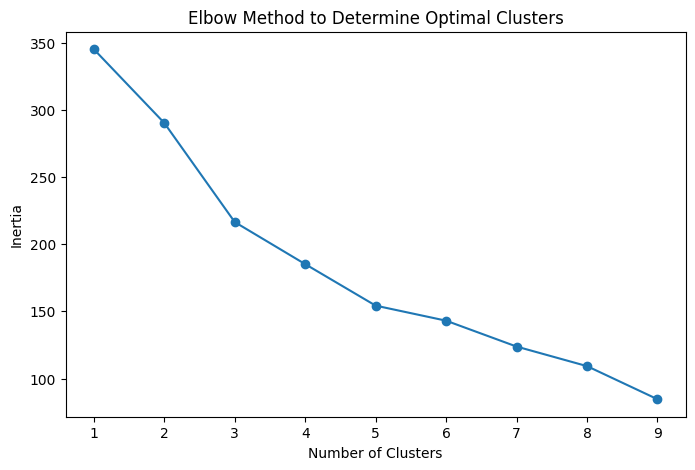

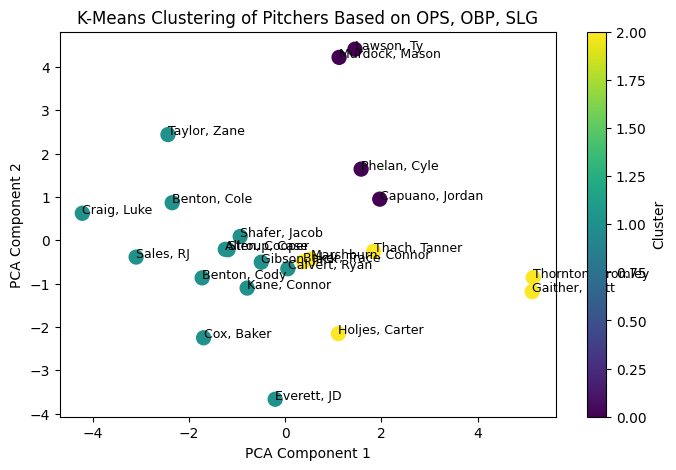

              Pitcher       OBP       SLG       OPS  Cluster
0           Sales, RJ  0.394191  0.382199   0.77639        1
1         Craig, Luke  0.401709  0.355556  0.757265        1
2        Kane, Connor  0.458824  0.471429  0.930252        1
3       Shafer, Jacob  0.428571  0.529412  0.957983        1
4        Stroup, Case  0.450000  0.508772  0.958772        1
5        Baker, Trace  0.459459  0.584906  1.044365        2
6          Lawson, Ty  0.666667       0.6  1.266667        0
7        Benton, Cole  0.406250  0.391304  0.797554        1
8      Murdock, Mason  0.578947  0.521739  1.100686        0
9        Taylor, Zane  0.380597  0.586207  0.966804        1
10      Calvert, Ryan  0.494382       0.7  1.194382        1
11  Marshburn, Connor  0.569444  0.489796   1.05924        2
12      Thach, Tanner  0.500000  0.888889  1.388889        2
13       Phelan, Cyle  0.578947  0.473684  1.052632        0
14         Cox, Baker  0.360000       0.5      0.86        1
15  Thornton, Bromley  0

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'ops_df' is the real DataFrame containing calculated OPS, OBP, and SLG metrics for each pitcher
# Example: leverage_ops_df from the leverage calculations or handiness_ops_df from the handiness calculations

# Select numerical features (e.g., OPS, OBP, SLG for leverage or handiness)
features = ['OPS_Low', 'OPS_Medium', 'OPS_High', 'OBP_Left', 'OBP_Right', 'SLG_Left', 'SLG_Right']
X = combined_ops_df[features]
import numpy as np

X = combined_ops_df.drop(columns=['Pitcher']).replace('N/A', np.nan).astype(float)
X = X.fillna(X.mean())
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Fit K-Means with the optimal number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
ops_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ops_df['Cluster'], cmap='viridis', s=100)
plt.title('K-Means Clustering of Pitchers Based on OPS, OBP, SLG')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
for i, pitcher in enumerate(ops_df['Pitcher']):
    plt.text(X_pca[i, 0], X_pca[i, 1], pitcher, fontsize=9)
plt.colorbar(label='Cluster')
plt.show()

# Display the clustered data
print(ops_df)


## Random Forest

In [ ]:
# Define thresholds for success (e.g., league average OPS)
ops_threshold = 0.750  # Example threshold
combined_ops_df = combined_ops_df.drop(columns=['Pitcher']).replace('N/A', np.nan).astype(float)
combined_ops_df = combined_ops_df.fillna(X.mean())
# Create binary success columns for each situation
combined_ops_df['Success_Low'] = (combined_ops_df['OPS_Low'] < ops_threshold).astype(int)
combined_ops_df['Success_Medium'] = (combined_ops_df['OPS_Medium'] < ops_threshold).astype(int)
combined_ops_df['Success_High'] = (combined_ops_df['OPS_High'] < ops_threshold).astype(int)
# Define a general success column for a specific situation (e.g., high leverage, left-handed batter)
combined_ops_df['Success'] = (combined_ops_df['OPS_High'] < ops_threshold).astype(int)


<ipython-input-69-7c25e0a356a3>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_ops_df = combined_ops_df.drop(columns=['Pitcher']).replace('N/A', np.nan).astype(float)
